# Autoencoder

We will try to classify Stocks Families and Time Periods similiarities using the following Data Set: sp500.csv.gz

### Goals:

- Implement autoencoders using the functional API.

- Compare results with Variational Autoencoders (VAEs).

- Analyze encodings and generated time series.


An Autoencoder (AE) is an unsupervised neural network whose objective is to learn a compressed representation (encoding) of the input data. Unlike a classical neural network that predicts a target y (supervised), an AE tries to predict its own input x. It aims to learn the identity function:

$$\hat{x}=D(E(x))≈x$$

1. The Encoder E(.) is the first neural layer, use to obtain the latent vector $z$

2. The Bottleneck is the central neural layer with a smaller dimension

3. The Decoder D(.): It attempts to reconstruct x from z. $$\hat


The objective of this lab is to extract this z for asset clustering:

We will train our model using empirocal S&P500 returns so as to minimize a given Loss Function (MSE for instance). This will allow us to extract z and thus classify stocks based on their relative behaviors to the market.

## 0. Prerequisites & Setup

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K

In [5]:
df_options = pd.read_csv('sp500.csv.gz', index_col=0, parse_dates=True)

# Remove NaN values and keep the 100 first tickers
df = df_options.dropna(axis=1)
df = df.select_dtypes(include=['number'])
df = df.iloc[:, :100]

# We rescale the daily returns by the the volatility of the market on that day
market_vol_series = df.std(axis=1)
df_scaled = df.div(market_vol_series, axis=0)

print(df_scaled.shape)
df_scaled.head()

(3145, 100)


,A,AABA,ABC,ABT,ADBE,ADI,ADP,ADSK,AEE,AEP,...,DTE,DUK,DVN,EA,EBAY,ECL,ED,EFX,EIX,EL
index,,,,,,,,,,,,,,,,,,,,,
2006-01-03,0.445457,3.118039,1.466891,0.214909,3.515489,1.633979,0.661539,-0.328826,0.854442,0.514052,...,0.866548,1.003280,2.427618,1.390440,1.975600,-1.109755,0.563948,0.891516,1.878329,-0.295286
2006-01-04,0.179879,0.098199,-0.443621,0.101575,-0.655746,0.620293,0.216777,-0.398442,-0.335679,-0.107530,...,-0.168460,-0.072150,1.345519,1.569064,0.075298,-0.618913,0.000000,-0.660856,0.717857,3.333698
2006-01-05,1.942937,1.013697,-0.918643,0.805100,-0.675611,2.362637,-0.622278,-1.091789,-0.632396,-0.417538,...,-0.629219,-0.533353,-0.921556,1.698177,2.282700,0.629031,-0.047642,-0.719838,-0.688362,-1.313741
2006-01-06,0.295924,2.292435,-0.628750,1.203025,1.384362,0.222408,0.491816,3.275383,0.830769,0.886178,...,0.602867,0.369450,1.234782,0.730696,1.062245,0.603712,0.169996,0.525413,0.227538,-0.214283
2006-01-09,-0.195688,0.329535,0.000000,2.520538,-1.060552,0.954264,-0.175020,-0.995118,-0.326555,-1.007997,...,-0.062065,0.146396,-0.142556,-0.527485,-0.203098,-0.357368,-0.086912,0.711872,-0.798424,0.752298


In [6]:
# Functional Autoencoder Builder
def build_ae(input_dim, latent_dim, hidden_dim=64):
    """
    Constructs an Autoencoder using the Functional API.
    Returns:
        ae: The full autoencoder model (x -> x_hat)
        encoder: The encoder model (x -> z)
        decoder: The decoder model (z -> x_hat)
    """
    # Encoder
    inputs = keras.Input(shape=(input_dim,), name='input_layer')

    h_enc = layers.Dense(hidden_dim, activation='relu', name='encoder_hidden')(inputs) # Hidden layer
    z = layers.Dense(latent_dim, activation='linear', name='bottleneck')(h_enc) # Bottleneck

    encoder = keras.Model(inputs, z, name='encoder') # Instantiate Encoder Model


    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')

    h_dec = layers.Dense(hidden_dim, activation='relu', name='decoder_hidden')(latent_inputs) # Hidden layer
    outputs = layers.Dense(input_dim, activation='linear', name='output_layer')(h_dec) # Output layer

    decoder = keras.Model(latent_inputs, outputs, name='decoder') # Instantiate Decoder Model


    # Full Autoencoder
    outputs_ae = decoder(encoder(inputs))
    ae = keras.Model(inputs, outputs_ae, name='autoencoder')

    return ae, encoder, decoder

## 1. Asset Categorization

In this Part, we will:

- Separate the assets into training, validation, and test sets.  
- Train an autoencoder with the rescaled returns of the assets from the training set. Note that the row index in this context denotes the securities and the column index denotes time.


In [7]:
# Transpose the dataframe
X = df_scaled.T.values

# Split Train/Test/Val (64%/20%/16%)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

## 1.1 Autoencoders


In [8]:
# First we define the Sign Accuracy Metric
def get_sign_accuracy(y_true, y_pred):
    """
    Returns the fraction of times the sign is predicted correctly
    """
    return np.mean(np.sign(y_true) == np.sign(y_pred))

# Train with different Bottleneck sizes
B_list = [1, 2, 5, 10, 20, 50, 100]
train_acc = []
test_acc = []

input_dim = X_train.shape[1] # Number of days (T)

print(f"Training on {input_dim} days/features...")

for B in B_list:
    # 1. Build
    ae, encoder, decoder = build_ae(input_dim, latent_dim=B)
    ae.compile(optimizer='adam', loss='mse')

    # 2. Train
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    ae.fit(X_train, X_train, epochs=30, batch_size=16,
           validation_data=(X_val, X_val), verbose=0, callbacks=[callback])

    # 3. Predict
    pred_train = ae.predict(X_train, verbose=0)
    pred_test = ae.predict(X_test, verbose=0)

    # 4. Compute Sign Accuracy
    acc_tr = get_sign_accuracy(X_train, pred_train)
    acc_te = get_sign_accuracy(X_test, pred_test)

    train_acc.append(acc_tr)
    test_acc.append(acc_te)

    print(f"B={B} | Train Sign Acc: {acc_tr:.4f} | Test Sign Acc: {acc_te:.4f}")

Training on 3145 days/features...
B=1 | Train Sign Acc: 0.7058 | Test Sign Acc: 0.6957
B=2 | Train Sign Acc: 0.7278 | Test Sign Acc: 0.7071


B=5 | Train Sign Acc: 0.7738 | Test Sign Acc: 0.7316
B=10 | Train Sign Acc: 0.7879 | Test Sign Acc: 0.7330
B=20 | Train Sign Acc: 0.7609 | Test Sign Acc: 0.7208
B=50 | Train Sign Acc: 0.8001 | Test Sign Acc: 0.7325
B=100 | Train Sign Acc: 0.8001 | Test Sign Acc: 0.7321


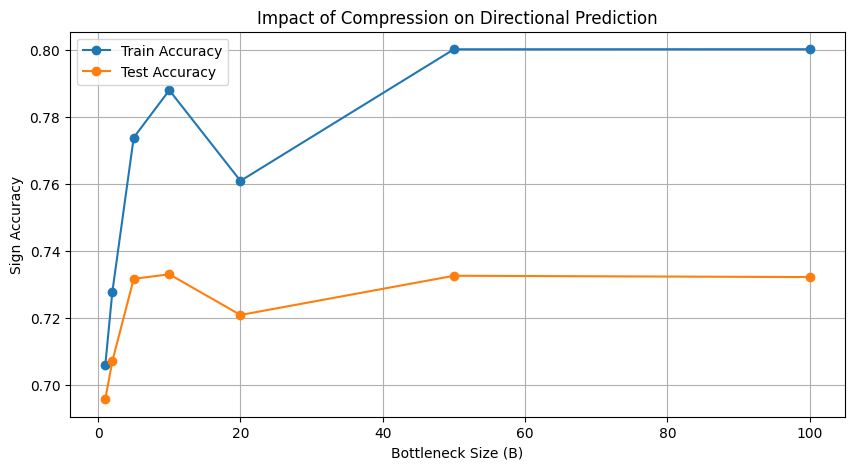

In [9]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(B_list, train_acc, marker='o', label='Train Accuracy')
plt.plot(B_list, test_acc, marker='o', label='Test Accuracy')
plt.xlabel('Bottleneck Size (B)')
plt.ylabel('Sign Accuracy')
plt.title('Impact of Compression on Directional Prediction')
plt.legend()
plt.grid(True)
plt.show()

When the bottleneck Size increase, we increase the Directional Prediction However, we also increase the number of predicted clusters.

Training B=2 model for visualization...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


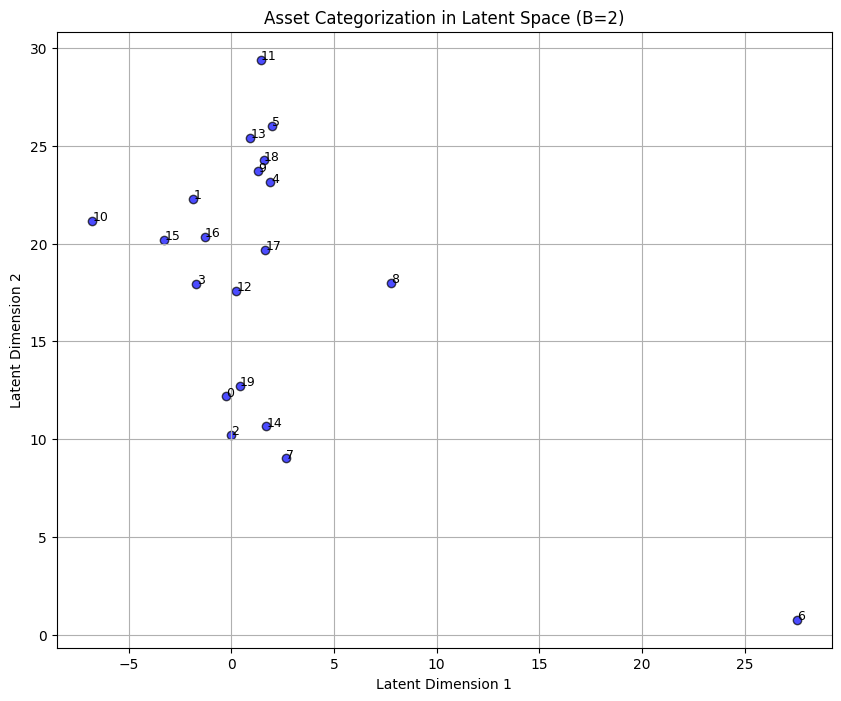

In [10]:
# Visualizing the Latent Space (B=2)
latent_dim_viz = 2
ae_2, enc_2, dec_2 = build_ae(input_dim, latent_dim_viz)
ae_2.compile(optimizer='adam', loss='mse')

print("Training B=2 model for visualization...")
ae_2.fit(X_train, X_train, epochs=50, batch_size=16,
         validation_data=(X_val, X_val), verbose=0)

# Extract Latent Features (z)
z_test = enc_2.predict(X_test)

# --- Plot Latent Space ---
plt.figure(figsize=(10, 8))
plt.scatter(z_test[:, 0], z_test[:, 1], c='blue', alpha=0.7, edgecolors='k')

# Annotate with names
for i in range(len(z_test)):
    plt.text(z_test[i, 0]+0.02, z_test[i, 1]+0.02, str(i), fontsize=9)

plt.title('Asset Categorization in Latent Space (B=2)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

Using a Bi-dimensional bottleneck, we can roughly discriminate 3 differente asset clusters.

## 1.2 Variational Autoencoder (VAE)

Why VAE for Assets?

- A standard AE maps a stock's history to a single point z.

- A VAE maps a stock's history to a cloud of probability (defined by mean μ and spread σ).

- Clustering: The μ vector gives you the "position" of the stock in the latent space (e.g., "Tech Stock"). The σ vector tells you how "sure" the model is. If σ is large, the stock doesn't fit neatly into a category; it's an outlier or a hybrid.

In [11]:
# Sampling Layer (VAE Particularity)
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Loss Computing Layer
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        # On déballe les 4 entrées nécessaires
        x_true, x_pred, z_mean, z_log_var = inputs

        # Calcul de la Loss de Reconstruction (MSE)
        # tf.shape(x_true)[1] nous donne 'input_dim' dynamiquement
        input_dim = tf.cast(tf.shape(x_true)[1], tf.float32)
        reconstruction_loss = tf.reduce_mean(tf.square(x_true - x_pred)) * input_dim

        # Calcul de la Loss KL (Régularisation)
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        # On ajoute la loss totale au modèle
        self.add_loss(reconstruction_loss + kl_loss)

        # On retourne simplement la prédiction (pass-through)
        return x_pred

# Build VAE Function
def build_vae_asset(input_dim, latent_dim, hidden_dim=64):

    # Encoder
    inputs = keras.Input(shape=(input_dim,))
    h = layers.Dense(hidden_dim, activation='relu')(inputs)

    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    h_dec = layers.Dense(hidden_dim, activation='relu')(latent_inputs)
    outputs = layers.Dense(input_dim, activation='linear')(h_dec)

    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    # Full VAE
    outputs_vae = decoder(z)
    outputs_final = VAELossLayer()([inputs, outputs_vae, z_mean, z_log_var])
    vae = keras.Model(inputs, outputs_final, name="vae")

    return vae, encoder, decoder

In [12]:
# Train
input_dim = X_train.shape[1]
latent_dim = 2 # Visualization in 2D

vae_asset, enc_asset, dec_asset = build_vae_asset(input_dim, latent_dim)
vae_asset.compile(optimizer='adam')

print(f"Training Asset VAE on {X_train.shape[0]} assets...")
vae_asset.fit(X_train, X_train,
              epochs=50,
              batch_size=16,
              validation_data=(X_val, X_val),
              verbose=0)

Training Asset VAE on 64 assets...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


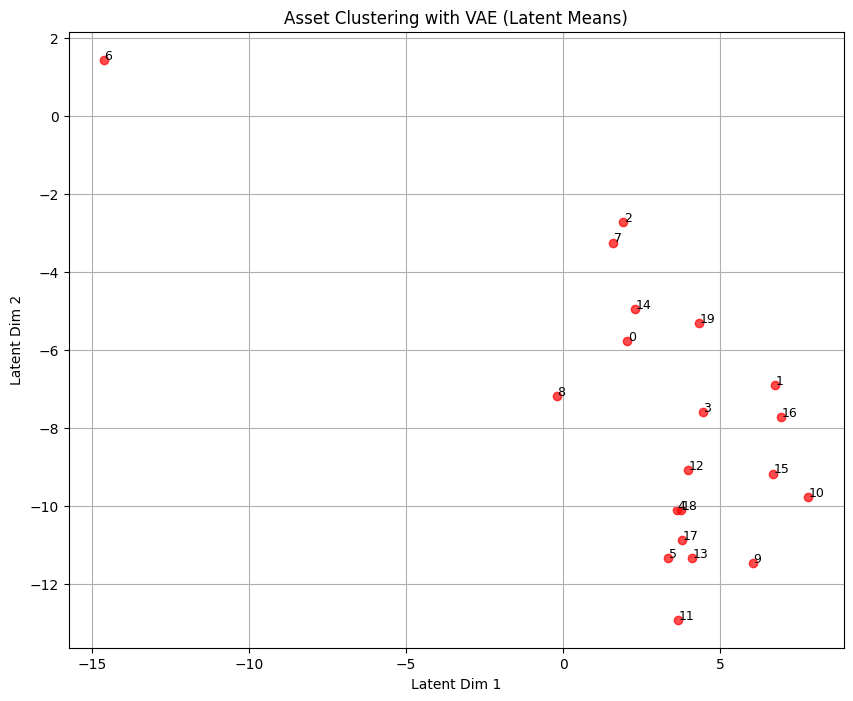

In [13]:
# Plot
# We use the Mean (z_mean) as the "position" of the asset
z_mean_test, z_log_var_test, _ = enc_asset.predict(X_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_mean_test[:, 0], z_mean_test[:, 1], c='red', alpha=0.7)

# On parcourt tous les points prédits
for i in range(len(z_mean_test)):
    # On place le texte un tout petit peu décalé (+0.02) par rapport au point
    plt.text(z_mean_test[i, 0]+0.02, z_mean_test[i, 1]+0.02, str(i), fontsize=9)

plt.title("Asset Clustering with VAE (Latent Means)")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.grid(True)
plt.show()

Once again, we roughly observe the same 3 clusters than with the simple AE. However point 8 would be now clustered differently.

## 2. Market States

In the first part, we were trying to group similar behaving stocks. In this second part, we will try to find time patenrs by clustering time periods.

In [14]:
# Data Preparation for Market States
X_states = df_scaled.values # We do not transpose here

# Split Train/Test/Val on days
X_train_s, X_test_s = train_test_split(X_states, test_size=0.2, random_state=42)
X_train_s, X_val_s = train_test_split(X_train_s, test_size=0.2, random_state=42)

print(f"Input shape (Assets per day): {X_train_s.shape[1]}")
print(f"Training on {X_train_s.shape[0]} days.")

Input shape (Assets per day): 100
Training on 2012 days.


### 2.1 Market States (AE)

In [15]:
# Train AE on Market States
input_dim_s = X_train_s.shape[1]
latent_dim_s = 2

ae_states, enc_states, dec_states = build_ae(input_dim_s, latent_dim_s)
ae_states.compile(optimizer='adam', loss='mse')

# Train
history_states = ae_states.fit(X_train_s, X_train_s,
                               epochs=30,
                               batch_size=32,
                               validation_data=(X_val_s, X_val_s),
                               verbose=0)

In [16]:
# Metric: Sign Accuracy
# Check if the model captures the general direction of the market
pred_test_s = ae_states.predict(X_test_s, verbose=0)
sign_acc = np.mean(np.sign(X_test_s) == np.sign(pred_test_s))
print(f"Market State Reconstruction Sign Accuracy: {sign_acc:.4f}")

Market State Reconstruction Sign Accuracy: 0.7240


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


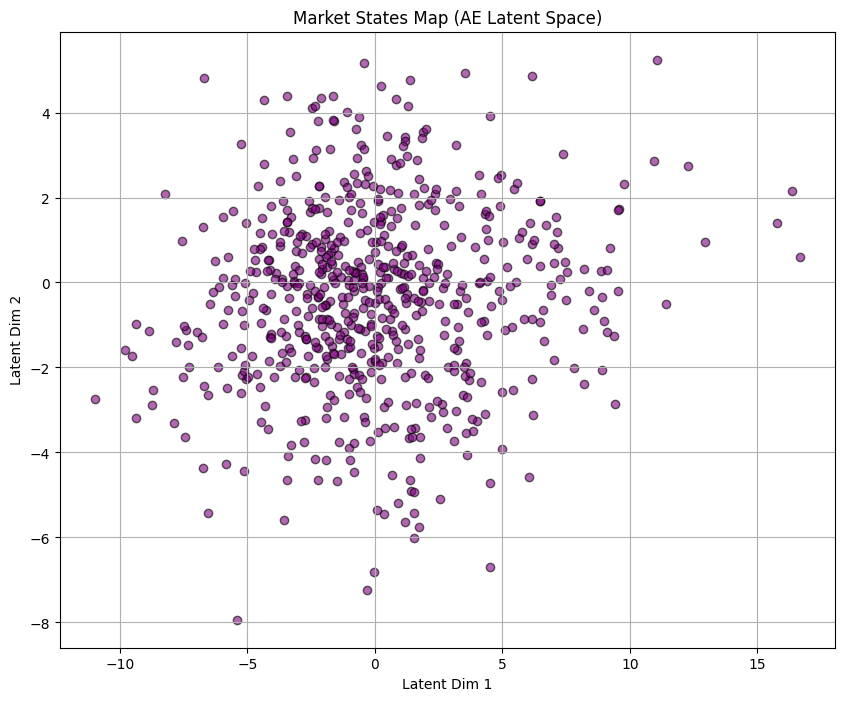

In [17]:
# Plot
z_states = enc_states.predict(X_test_s)

plt.figure(figsize=(10, 8))
plt.scatter(z_states[:, 0], z_states[:, 1], c='purple', alpha=0.6, edgecolors='k')
plt.title("Market States Map (AE Latent Space)")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.grid(True)
plt.show()

This is becoming harder to make conclusions in 2 dimension, we will certainly need to increase dimension to be able to differentiate the different clusters.

### 2.2 Market States (VAE)

In [18]:
from scipy.stats import gaussian_kde

In [19]:
# Train VAE on Market States
input_dim_s = X_train_s.shape[1]
latent_dim_s = 2

ae_states, enc_states, dec_states = build_ae(input_dim_s, latent_dim_s)
ae_states.compile(optimizer='adam', loss='mse')

# Train
history_states = ae_states.fit(X_train_s, X_train_s,
                               epochs=30,
                               batch_size=32,
                               validation_data=(X_val_s, X_val_s),
                               verbose=0)

In [20]:
#  Metric: Sign Accuracy
pred_test_s = ae_states.predict(X_test_s, verbose=0)
sign_acc = np.mean(np.sign(X_test_s) == np.sign(pred_test_s))
print(f"Market State Reconstruction Sign Accuracy: {sign_acc:.4f}")

Market State Reconstruction Sign Accuracy: 0.7221


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


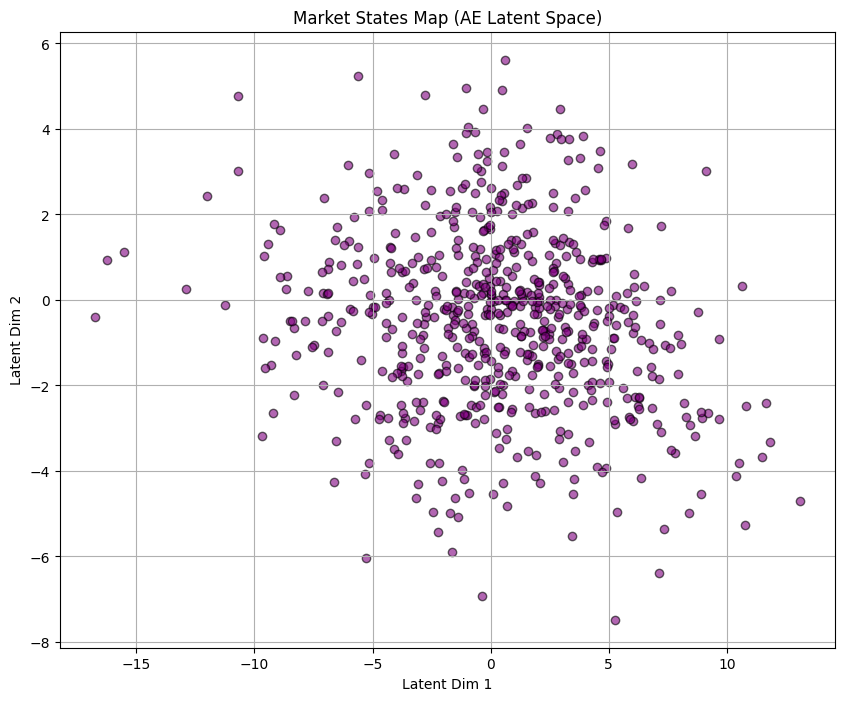

In [21]:
# Plot
z_states = enc_states.predict(X_test_s)

plt.figure(figsize=(10, 8))
plt.scatter(z_states[:, 0], z_states[:, 1], c='purple', alpha=0.6, edgecolors='k')
plt.title("Market States Map (AE Latent Space)")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.grid(True)
plt.show()

As with AE, this is becoming harder to make conclusions in 2 dimension, we will certainly need to increase dimension to be able to differentiate the different clusters.

### Heatmap (D=3)

Let's try introducing a third dimension

Entraînement du modèle 3D...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


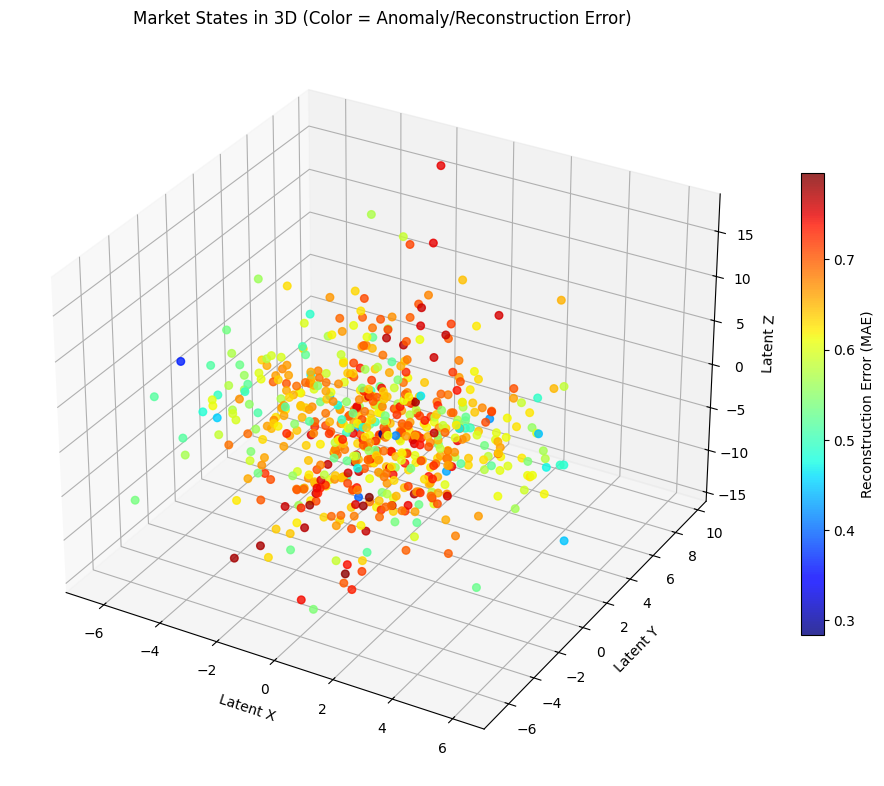

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Ré-entraînement avec Latent Dim = 3 ---
latent_dim_3d = 3
input_dim_s = X_train_s.shape[1] # 100 actifs

# On utilise l'AE classique pour la géométrie pure (marche aussi avec VAE)
ae_3d, enc_3d, _ = build_ae(input_dim_s, latent_dim_3d)
ae_3d.compile(optimizer='adam', loss='mse')

print("Entraînement du modèle 3D...")
ae_3d.fit(X_train_s, X_train_s, epochs=30, batch_size=32, verbose=0)

# --- 2. Préparation des Données pour la Heatmap ---
# On projette les états de marché en 3D
z_3d = enc_3d.predict(X_test_s)

# On calcule l'erreur de reconstruction pour chaque jour (Heatmap metric)
# Plus l'erreur est grande, plus le jour est "anormal"
reconstructions = ae_3d.predict(X_test_s, verbose=0)
mae_per_day = np.mean(np.abs(X_test_s - reconstructions), axis=1)

# --- 3. Tracé 3D avec Heatmap ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
# c=mae_per_day : La couleur dépend de l'erreur (Heatmap)
# cmap='jet' : Du bleu (calme) au rouge (anomalie)
sc = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2],
                c=mae_per_day, cmap='jet', s=30, alpha=0.8)

# Légendes et Titres
ax.set_title("Market States in 3D (Color = Anomaly/Reconstruction Error)")
ax.set_xlabel("Latent X")
ax.set_ylabel("Latent Y")
ax.set_zlabel("Latent Z")

# Barre de couleur (Heatmap legend)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label('Reconstruction Error (MAE)')

plt.show()

It is still difficult to deduce any clusters right away.

## Using (V)AEs for Prediction

There are two primary approaches to using these architectures for prediction:

- Indirect Prediction via Feature Extraction (Latent States): The encoder compresses the high-dimensional input X (e.g., stock returns) into a lower-dimensional latent state z. This vector z represents "simplified information" or features of the system. So we can apply prediction algorithm in the latent state instead !

- Generative Prediction (Scenario Generation): This is specific to VAEs. Since VAEs learn the underlying distribution of the data, they can be used as scenario generators. We could for instance use it in MonteCarlo Simulation to compute a portfolio gloabal payoff.

## 3. Anomaly Detection

### 3.1 Time Period Anomalies

We ensure X_states_full represents the full, ordered dataset (not shuffled), so the dates align correctly with the x-axis.

In [23]:
X_states_full = df_scaled.values
dates = df_scaled.index
stock_names = df_scaled.columns

In [24]:
reconstructions = ae_states.predict(X_states_full)

# Calculate MAE per day
mae_per_day = np.mean(np.abs(X_states_full - reconstructions), axis=1)

# Calculate average market volatility for comparison
market_volatility = np.std(X_states_full, axis=1)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


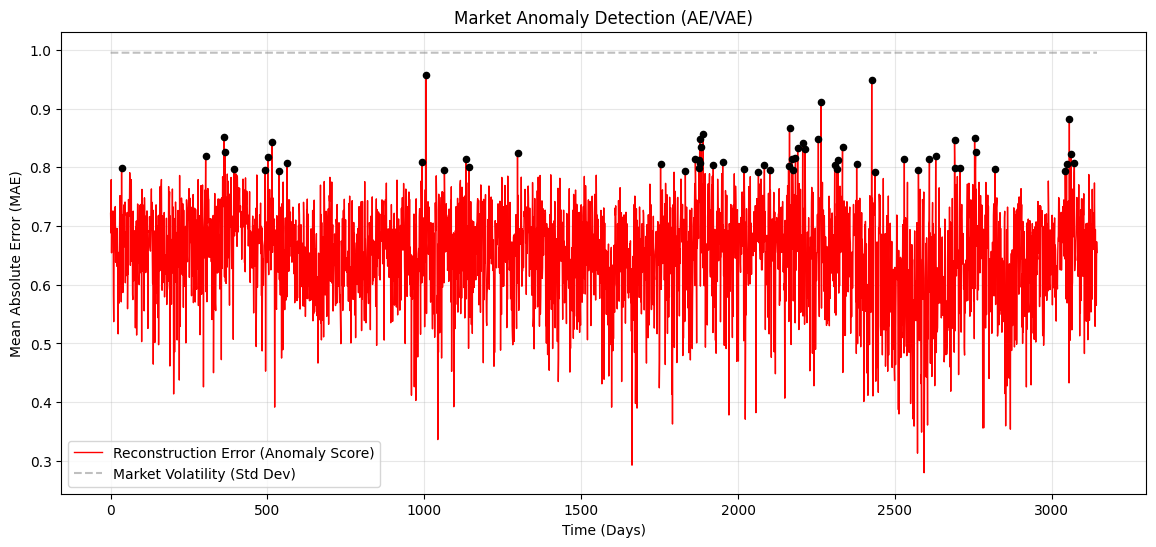

In [25]:
# Plot
plt.figure(figsize=(14, 6))

# Plot the reconstruction error
plt.plot(mae_per_day, label='Reconstruction Error (Anomaly Score)', color='red', linewidth=1)
plt.plot(market_volatility, label='Market Volatility (Std Dev)', color='grey', alpha=0.5, linestyle='--')

plt.title("Market Anomaly Detection (AE/VAE)")
plt.xlabel("Time (Days)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True, alpha=0.3)

# Identify "Crisis" days (Top anomalies)
threshold = np.percentile(mae_per_day, 98) # Threshold at top 2%
anomalies_idx = np.where(mae_per_day > threshold)[0]
plt.scatter(anomalies_idx, mae_per_day[anomalies_idx], color='black', s=20, zorder=5, label='Anomalies')

plt.show()

In [ ]:
# Récupération des dates et des erreurs correspondantes
anomaly_dates = df_scaled.index[anomalies_idx]
anomaly_scores = mae_per_day[anomalies_idx]

df_anomalies = pd.DataFrame({'Date': anomaly_dates, 'Erreur (MAE)': anomaly_scores})
df_anomalies['Date'] = pd.to_datetime(df_anomalies['Date'])

# Plot
print(f"--- Top {len(df_anomalies)} Anomaly Detection (Seuil 98%) ---")

# We filter then based on the gravity of the MAE error:
print("\nFilter by Intensity:")
print(df_anomalies.sort_values(by='MAE (Errors)', ascending=False).head(15))

--- Top 63 Anomaly Detection (Seuil 98%) ---

Filter by Intensity:
         Date  Erreur (MAE)
11 2009-12-31      0.956756
46 2015-08-24      0.948277
40 2014-12-31      0.910465
60 2018-02-23      0.881942
32 2014-08-08      0.866393
24 2013-07-08      0.856887
2  2007-06-13      0.851818
55 2016-12-09      0.849279
39 2014-12-18      0.848479
21 2013-06-20      0.848109
52 2016-09-09      0.846073
7  2008-01-22      0.843079
37 2014-10-08      0.842137
44 2015-04-13      0.834515
23 2013-06-26      0.834022


We can interpret some of the major anomalies:

- 2015-08-24: This was the 'Black Monday' of the 2015 crash: At the opening, the Dow Jones lost 1000 points in a few minutes.
- 2013-06-26 / 2013-07-08: Ben Bernanke (Fed) announced that the central bank would slow its asset purchases. Bond rates surged, causing panic in the stock market.
- 2008-01-22: Kerviel Case: Société Générale unwound a 50 billion dollar position in one day.
- 2013-06-26: Ben Bernanke announced that the Fed would start slowing down the bond buyback.
- 2014-10-08 / 2014-12-18: OPEC commercial war alongside Russian sanctions.



### 3.2 Stock Anomalies

In [28]:
# Reconstruction Error per Stock

# Calculate Mean Absolute Error (MAE) per stock
mae_per_stock = np.mean(np.abs(X_states_full - reconstructions), axis=0)
stock_names = df_scaled.columns

stock_anomalies = pd.Series(mae_per_stock, index=stock_names)
top_anomalies_stocks = stock_anomalies.sort_values(ascending=False)

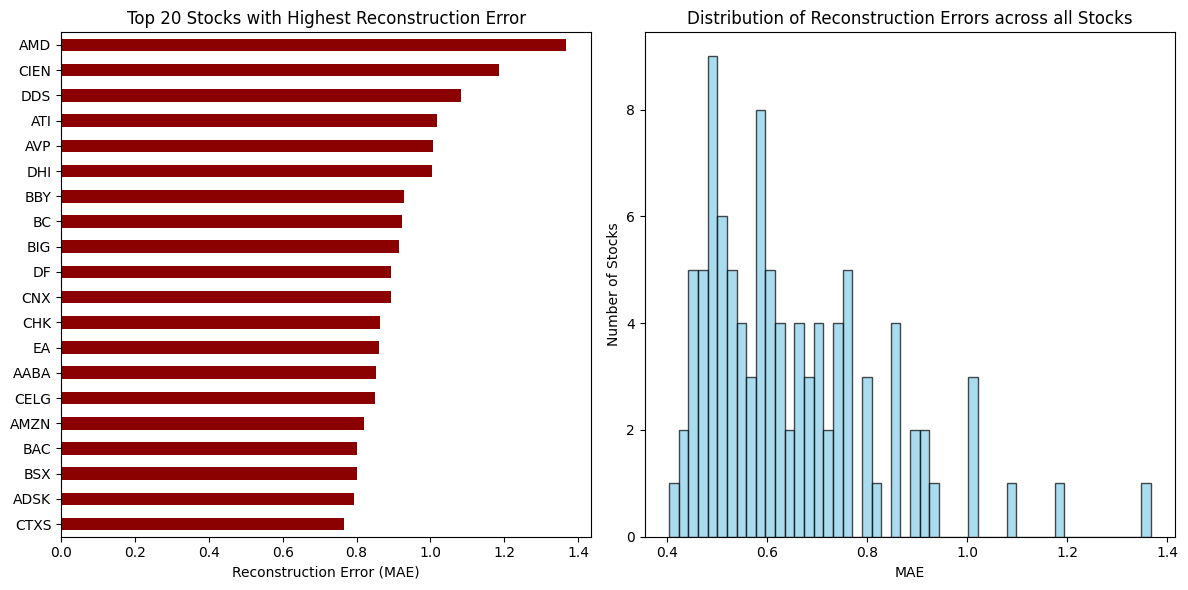

--- Most Anomalous Stocks ---
AMD     1.367458
CIEN    1.186729
DDS     1.083408
ATI     1.016545
AVP     1.006043
DHI     1.004246
BBY     0.928732
BC      0.921969
BIG     0.915051
DF      0.894109
dtype: float64


In [29]:
# Plot
plt.figure(figsize=(12, 6))

# Plot 1: Top 20 Anomalous Stocks
plt.subplot(1, 2, 1)
top_anomalies_stocks.head(20).plot(kind='barh', color='darkred')
plt.title('Top 20 Stocks with Highest Reconstruction Error')
plt.xlabel('Reconstruction Error (MAE)')
plt.gca().invert_yaxis() # To have the #1 at the top

# Plot 2: Distribution of Errors
plt.subplot(1, 2, 2)
plt.hist(mae_per_stock, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Reconstruction Errors across all Stocks')
plt.xlabel('MAE')
plt.ylabel('Number of Stocks')

plt.tight_layout()
plt.show()

# Display the Top 10 list
print("--- Most Anomalous Stocks ---")
print(top_anomalies_stocks.head(10))

We can interpret some of the major anomalies:

- AMD (Advanced Micro Devices): Extreme variance; the stock survived near-bankruptcy in the early 2010s before staging a massive, exponential tech comeback.

- DHI (D.R. Horton): Located at the epicenter of the 2008 Subprime crisis; as a homebuilder, it collapsed earlier and steeper than the wider market.

- BBY (Best Buy): Experienced a massive "V-shaped" volatility: crashed in 2012 on fears of obsolescence (vs. Amazon), then rallied sharply after a successful restructuring.

- BC (Brunswick Corp): Ultra-cyclical luxury (boats); the stock lost ~90% of its value in 2008 as discretionary spending froze, creating huge reconstruction errors.

- DF (Dean Foods): A terminal anomaly; the company faced a slow "death spiral" due to declining milk consumption, leading to bankruptcy filings in 2019.

To conclude, Autoencoder is a powerfull tool that can be used to classify stocks and time period effectively aswell as for fiding outliers.